<a href="https://colab.research.google.com/github/marcinmichalsmolen/ZUM/blob/main/ZUM2NLP2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ZUM_NLP Marcin Smoleń s23429**

Celem projektu jest stworzenie analizatora sentymentu do analizy polaryzacji społeczeństwa w Polsce na podstawie tweetów na temat COVID-19

Dane wejściowe znajdują w formacie json pod adresem http://77.55.209.58/zum2/tweets.json

Do odszumiania wykorzystano spacy i listę dla polskiego języka pl_core_news_md

Na początku do analizy sentymentu została wykorzystana została biblioteka TextBlob Do tokenizacji nltk.tokenize Do klasyfikacji użyto narzędzi z pakietu sklearn m.in naiwny klasyfikator Bayesa BernoulliNB oraz LinearSVC



In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!python -m pip install spacy==3.2.0 -q
!python -m spacy download pl_core_news_md

Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.1/671.1 KB 43.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.2.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 MB 11.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_md')


Import bibliotek i wczytanie zbioru tweetów z mojego serwera

In [2]:
import numpy as np
import pandas as pd
import string
import json
import re

DATASET_COLUMNS=['Id', 'text',]
DATASET_ENCODING = "UTF-8"
from pandas.core import frame
df=pd.read_json(path_or_buf='http://77.55.209.58/zum2/tweets.json',encoding=DATASET_ENCODING,typ=frame)
df

2012-03-04 10:17:01.616861185    [VIDEO] Premier: Przedstawiamy kompleksowy pla...
2011-10-23 17:01:55.487666178                                                     
2015-01-17 05:04:47.280467978       Nie no to jest Złoto 🤣 https://t.co/Rxrlckriug
2012-07-29 04:00:49.879867394    Czekam, kiedy Polski Związek Hodowców Gołębi P...
2013-02-08 14:30:29.840453643    Eksperci przewidują, że szczepionki przeciwko ...
                                                       ...                        
2009-10-18 20:27:38.570440704    Coraz więcej osób z personelu medycznego pisze...
2015-12-22 03:44:55.948939266    Najwyższa od marca liczba nowych zgonów na Cov...
2014-01-13 00:03:49.843283971                Czechs' loss. https://t.co/MdZP4V1B0k
2012-01-06 11:20:47.311114241    Kilka lat temy Pfizer zapłacił kilkadziesiat m...
2011-11-26 01:37:09.843283997                                                     
Length: 462124, dtype: object

In [3]:
from pandas.io.formats.info import DataFrameInfo
N = 10
df.sample(N) 
# Konwertuje dane do formatu Dataframe
data=pd.DataFrame(data=df)
data.index=pd.to_numeric(data.index)
data['label'] = None
data.columns=['text','label']
data.index.unique()
data

,text,label
1330856221616861185,[VIDEO] Premier: Przedstawiamy kompleksowy pla...,None
1319389315487666178,,None
1421471087280467978,Nie no to jest Złoto 🤣 https://t.co/Rxrlckriug,None
1343534449879867394,"Czekam, kiedy Polski Związek Hodowców Gołębi P...",None
1360333829840453643,"Eksperci przewidują, że szczepionki przeciwko ...",None
...,...,...
1255897658570440704,Coraz więcej osób z personelu medycznego pisze...,None
1450755895948939266,Najwyższa od marca liczba nowych zgonów na Cov...,None
1389571429843283971,Czechs' loss. https://t.co/MdZP4V1B0k,None
1325848847311114241,Kilka lat temy Pfizer zapłacił kilkadziesiat m...,None


Import bibliotek

In [4]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from textblob import TextBlob

In [5]:
def get_tweet_sentiment(tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(tweet)
        # Ustawienie sentymentu
        if analysis.sentiment.polarity > 0:
            return 'pozytywny'
        else:
            return 'negatywny'

In [6]:
for ind in data.index:
     data['label'][ind] = get_tweet_sentiment(data['text'][ind])

In [7]:
data

,text,label
1330856221616861185,[VIDEO] Premier: Przedstawiamy kompleksowy pla...,negatywny
1319389315487666178,,negatywny
1421471087280467978,Nie no to jest Złoto 🤣 https://t.co/Rxrlckriug,negatywny
1343534449879867394,"Czekam, kiedy Polski Związek Hodowców Gołębi P...",negatywny
1360333829840453643,"Eksperci przewidują, że szczepionki przeciwko ...",negatywny
...,...,...
1255897658570440704,Coraz więcej osób z personelu medycznego pisze...,negatywny
1450755895948939266,Najwyższa od marca liczba nowych zgonów na Cov...,negatywny
1389571429843283971,Czechs' loss. https://t.co/MdZP4V1B0k,negatywny
1325848847311114241,Kilka lat temy Pfizer zapłacił kilkadziesiat m...,negatywny


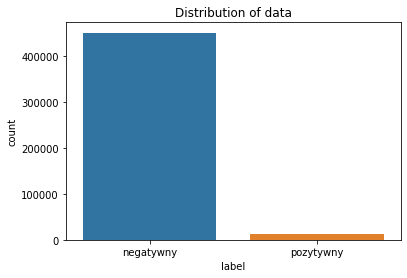

In [8]:
data.groupby('label').nunique()
ax = data.groupby('label').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['pozytywny','negatywny'], rotation=0)
sns.countplot(x='label', data=data)

In [9]:
data=data[['text','label']] 
pd.options.mode.chained_assignment = None
data_pos = data[data['label'].isin(['pozytywny'])]
data_neg = data[data['label'].isin(['negatywny'])]
print(data_neg)
print(data_pos)
dataset = pd.concat([data_pos, data_neg])
dataset= dataset.applymap(lambda s:s.lower() if type(s) == str else s)
dataset.sample(100)

                                                                  text  \
1330856221616861185  [VIDEO] Premier: Przedstawiamy kompleksowy pla...   
1319389315487666178                                                      
1421471087280467978     Nie no to jest Złoto 🤣 https://t.co/Rxrlckriug   
1343534449879867394  Czekam, kiedy Polski Związek Hodowców Gołębi P...   
1360333829840453643  Eksperci przewidują, że szczepionki przeciwko ...   
...                                                                ...   
1255897658570440704  Coraz więcej osób z personelu medycznego pisze...   
1450755895948939266  Najwyższa od marca liczba nowych zgonów na Cov...   
1389571429843283971              Czechs' loss. https://t.co/MdZP4V1B0k   
1325848847311114241  Kilka lat temy Pfizer zapłacił kilkadziesiat m...   
1322271429843283997                                                      

                         label  
1330856221616861185  negatywny  
1319389315487666178  negatywny  
142147108728

,text,label
1428627173607411714,japonia: odszkodowania dla 29 osób za skutki u...,negatywny
1399819057453539330,w @radiowajedynka @wiecejswiata o konieczności...,negatywny
1244587192741134337,alerta por spam https://t.co/71pxycbnjj,negatywny
1343970040165482496,ruszyły szczepienia przeciw covid-19 https://t...,negatywny
1378281478472273920,obostrzenia z powodu #pandemia #covid19 są bol...,negatywny
...,...,...
1437865744881041417,▪️pandemia covid-19 daje władzy powody do stos...,negatywny
1344323363611795457,,negatywny
1338135692023635971,covid-19 w rosji zabójczy jak wojna z finami. ...,negatywny
1363518123224281089,"pastor o #obostrzenia: ""czas na modlitwę o boż...",negatywny


Wczytywanie zbioru stopwords do odszumienia danych i wyświetlenie jego zawartości

In [10]:
nlp = spacy.load('pl_core_news_md')
stopwordlist = nlp.Defaults.stop_words
print(stopwordlist)

{'nigdy', 'tutaj', 'kilku', 'iż', 'raz', 'ktory', 'acz', 'ani', 'coraz', 'od', 'każdy', 'obok', 'tak', 'tobą', 'pod', 'takich', 'nich', 'wtedy', 'kiedy', 'moja', 'nią', 'poza', 'cali', 'dość', 'dzis', 'żadnych', 'bylo', 'go', 'znowu', 'był', 'bo', 'nam', 'trzeba', 'ktorych', 'czyli', 'sobie', 'jednakże', 'mozna', 'bardziej', 'tym', 'poniewaz', 'moi', 'natychmiast', 'podczas', 'aj', 'mało', 'ktokolwiek', 'nas', 'nia', 'jak', 'dwa', 'taki', 'nami', 'jakas', 'przedtem', 'właśnie', 'żadna', 'mna', 'będę', 'znów', 'wszystkie', 'jako', 'wy', 'inne', 'ponad', 'iv', 'ci', 'żaden', 'jakiż', 'ok', 'no', 'sam', 'wielu', 'jego', 'będą', 'których', 'zadnych', 'twoje', 'między', 'przecież', 'dokad', 'ponieważ', 'jedna', 'ją', 'tys', 'kims', 'nasz', 'cokolwiek', 'według', 'wszystkim', 'prawie', 'tzw', 'co', 'tę', 'ktore', 'ona', 'być', 'ktorego', 'jeśli', 'też', 'takie', 'nic', 'was', 'dosc', 'jemu', 'mogą', 'jakiś', 'powinno', 'przed', 'sposob', 'kierunku', 'cie', 'ciebie', 'moje', 'lub', 'to', 'mam

In [11]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwordlist])
for ind in dataset.index:
     dataset['text'][ind] = cleaning_stopwords(dataset['text'][ind])
dataset.sample(10)
  

,text,label
1381821655530475524,szczepienia przeciw #covid19 zapisywać 58-latk...,negatywny
1476148853246201856,@cezaryrzad @grzesiowski_p odpowie https://t.c...,negatywny
1394687317688868865,prezydent poznania osobiście spotykał osobami ...,negatywny
1313550296396820480,"panie @dariuszklimczak , proszę fachowcem każd...",negatywny
1397060267209543680,"""ale to? stało elytom usa? najpierw mówily, po...",negatywny
1442247350509002753,daszak in 2017 admits fauci funded chinese cor...,negatywny
1257011276993232896,"hej hej, szukam zrobienia zadania selfie, nawi...",negatywny
1377181352802414592,"press f 653 osób, przegrały walkę. https://t.c...",negatywny
1355199612026499078,szwedzka agencja zdrowia publicznego wprowadze...,negatywny
1308029335501246471,zaszczepila covid19 padla rzadka chorobe. skon...,negatywny


In [12]:
dataset['text'].head()


1254789830061355008    #dobroczynność: https://t.co/u8yni5f4kt hmm......
1393531506367377410    @wredny07 kolejny mit, powielany miłośników op...
1480590833506258947    hahaha.. da ham'wa kurz jelacht. 😂🤣😜 https://t...
1359482250111426560    ☘️już (10/02) ewa #żyźniewska, pedagog prezes ...
1297349657765371905    magda szubanski delivers important coronavirus...
Name: text, dtype: object

In [13]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

for ind in dataset.index:
     dataset['text'][ind] = cleaning_punctuations(dataset['text'][ind])

dataset.sample(10)

,text,label
1351107943287173123,naklejka wejście maseczce zakupie 2 sztuk nakl...,negatywny
1376272049660952576,przekłamuje rzeczywistość lewicy pogrzeb ślub...,negatywny
1421156768789536768,mają rozmach sksyny siara httpstcoahyarjvlwh ...,negatywny
1430423701653233670,mzgovpl imidwarszawa covid19 rzadka choroba sp...,negatywny
1349766589508440065,pawelkubala krzysztofbukiel erdogan zaszczepił...,negatywny
1256531113113157632,kidawa2020 arlukowicz mkblonska robicie kpina ...,negatywny
1348327341706141697,mzgovpl 1 wykrycie sekwencji rna testem pcr oz...,negatywny
1418887135533359107,„szczepionki” covid19 środek ludobójczy dowód ...,negatywny
1265498282710753282,,negatywny
1417711660740001801,perspektywa spowodowanego covid19 uszkodzenia ...,negatywny


In [14]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
for ind in dataset.index:
     dataset['text'][ind] = cleaning_repeating_char(dataset['text'][ind])
dataset.sample(10)

,text,label
1352522002792386561,zachęcamy słuchania najbliższy poniedziałek 25...,negatywny
1379070163547459588,minęło zaledwie 5 dni kwietnia służba asar dru...,negatywny
1455621543418122242,musicie publikowac badan dotarlismy takiego pu...,negatywny
1269932417348825088,lezzzzzzzzgow 25k httpstcocoycouczxg,negatywny
1333864579307343872,,negatywny
1445729757052682245,szczepionkach covi19 znaleziono pasożyty https...,negatywny
1341541108241805312,opis szczepionki covi19 produkcji biontech amp...,negatywny
1239097243090722816,źródło httpstcopzra1xmvr httpstcojld4xhsec3,negatywny
1481898381098340352,deportują zdrowego sportowca zaszczepiony zara...,negatywny
1316433405010219008,covi19 mówi sprawdzam wątek obowiązkowy httpst...,negatywny


In [15]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https[^s]+))',' ',data)

for ind in dataset.index:
     dataset['text'][ind] = cleaning_URLs(dataset['text'][ind])

dataset.sample(10)

,text,label
1319678059201597440,najgłupszy pomysł morawieckim lepszy rozsądnyc...,negatywny
1259931373638422531,art 20 ustawy dotyczącej organizacji wyborów d...,negatywny
1373982504043081730,maciej wąsik wiceminister mswiagovpl weekend p...,negatywny
1376809617028702208,martakiermasz towarzystwo zdziczało 😡powinni s...,negatywny
1334199391054344196,weronikapawlak4 polskawruinie2 covi19 zaszczep...,negatywny
1384372225873227776,polska europejskim rekordzistą lepszych ma cią...,negatywny
1315973331561132032,objawy raka płuc mylą koronawirus liczba piln...,negatywny
1370326881355063296,grzegorzred morawieckim zapytał horbana obiecy...,negatywny
1251737055866036224,krozwad związku tym był ileś osób było ogromna...,negatywny
1340994159214272512,trochę sensu koronahucpie,negatywny


In [16]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
    
for ind in dataset.index:
     dataset['text'][ind] = cleaning_numbers(dataset['text'][ind])

dataset.sample(10)

,text,label
1353577127631876096,,negatywny
1246234304792932357,rona rona red rona blue rona just rona,negatywny
1472344470918209536,dalej pójdzie liczyć puszczą igrzyska,negatywny
1296450293438263296,💬min t kościński chcemy polaków rosła świadomo...,negatywny
1240630717564018694,najlepszym podziękowaniem uśmiech osoby odwied...,negatywny
1334610101689323521,teraz mateusz weźmie szczepionki umiłowanego n...,negatywny
1347495675328688133,🇪🇺 🌱 parlament europejski chce zielony ład pod...,negatywny
1350767067289579522,🗣️to informacje chciałoby przeczytać niedzieln...,negatywny
1333654807618473984,,negatywny
1319900482194853888,szok,negatywny


Tokenizacja

In [17]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

1254789830061355008                      [w, w]
1393531506367377410                [w, w, w, w]
1480590833506258947                         [w]
1359482250111426560    [w, w, w, w, w, w, w, w]
1297349657765371905                          []
Name: text, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

In [ ]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)


In [ ]:
def model_Evaluate(model):
  # Predykcja danych na danych testowych
  y_pred = model.predict(X_test)

  # Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
  print(classification_report(y_test, y_pred))

  # Obliczamy i wyświetlamy confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['negatywny','pozytywny']
  group_names n= ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
  return y_pred

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred1 = BNBmodel.predict(X_test)
print(y_pred1)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()